# 计算机网络体系结构第二次作业

作业要求：

> 1. 推导杜邦分析公式：ROE = 净利润率 x 总资产周转率 x 权益乘数，并简要分析宏观经济放缓对于 ROE 的影响。
> 2. 因为假的东西难以长久，看财报最好多看几年。1）利用 akshare 库获取上市公司的财务报表数据（代码参考附录 1），计算每只股票在 2021 年至 2023 年期间的 ROE（由于 akshare 没有给出归母净利润，这里假设净利润 = 归母净利润）。2）希望对同一板块的公司进行 ROE 的横向比较。
> 3. 在 2 的基础上，针对于 ROE 最高的公司，根据其某一年，如 2023 年的年度报表，进行杜邦分析。（markdown 画图可参考附录 2）

## 理论推导

### 杜邦分析公式

杜邦分析公式是一个用于分解公司 ROE 的公式，它将 ROE 分解为三个部分：净利润率、总资产周转率和权益乘数。具体推导如下：

$$
\begin{alignat*}{3}
    \text{净利润率}    & \coloneqq \frac{\text{归母净利润}}{\text{营业收入}} \tag{净利润率} \\
    \text{总资产周转率} & \coloneqq \frac{\text{营业收入}}{\text{平均总资产}} \tag{总资产周转率} \\
    \text{权益乘数}    & \coloneqq \frac{1}{1 - 资产负债率} \tag{权益乘数} \\
                      & = \frac{1}{1 - \frac{平均总负债}{平均总资产}} \\
                      & = \frac{平均总资产}{平均总资产 - 平均总负债} \\
                      & = \frac{\text{平均总资产}}{\text{净资产}} \\
    ROE               & \coloneqq \frac{\text{归母净利润}}{\text{净资产}} \tag{净资产收益率} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{净资产}} \\
                      & = \frac{\text{归母净利润}}{\text{营业收入}} \times \frac{\text{营业收入}}{\text{平均总资产}} \times \frac{\text{平均总资产}}{\text{净资产}} \\
                      & = \text{净利润率} \times \text{总资产周转率} \times \text{权益乘数}
\end{alignat*}
$$

## 实验设置


## 实验原理、实现、结果与分析


### 数据准备


In [1]:
from typing import Callable
from pylab import mpl
from matplotlib import pyplot as plt
import akshare as ak
import os
import os.path as path
import pandas as pd
import pathlib as pl


# 设置显示中文字体
mpl.rcParams["font.sans-serif"] = ["Songti SC"]
mpl.rcParams["axes.unicode_minus"] = False


class DataLoader:
    """
    Load data from akshare and save it to local file.
    """
    stock_zcfz_em_df: pd.DataFrame
    stock_lrb_em_df: pd.DataFrame
    stock_xjll_em_df: pd.DataFrame
    stock_yjbb_em_df: pd.DataFrame

    def __init__(self, date: str):
        self.load_data(date)

    @staticmethod
    def load_df(p: pl.Path, getter: Callable[[], pd.DataFrame]):
        '''
        Load DataFrame from local file, if the file does not exist, call getter to get the data.
        '''
        # 使用 pickle 格式保存数据以保证类型的准确和减少加载时间
        if not path.exists(p):
            df = getter()
            df.set_index("股票代码", inplace=True)
            df.to_pickle(p)
        return pd.read_pickle(p)

    def load_data(self, date: str):
        DIR = pl.Path("data")
        os.makedirs(DIR, exist_ok=True)
        self.stock_zcfz_em_df = self.load_df(
            DIR / f"stock_zcfz_em-{date}.pkl",
            lambda: ak.stock_zcfz_em(date=date)
        )
        self.stock_lrb_em_df = self.load_df(
            DIR / f"stock_lrb_em-{date}.pkl",
            lambda: ak.stock_lrb_em(date=date)
        )
        self.stock_xjll_em_df = self.load_df(
            DIR / f"stock_xjll_em-{date}.pkl",
            lambda: ak.stock_xjll_em(date=date)
        )
        self.stock_yjbb_em_df = self.load_df(
            DIR / f"stock_yjbb_em-{date}.pkl",
            lambda: ak.stock_yjbb_em(date=date)
        )

- 读取财务数据，并查看可用的信息。


In [2]:
DATES = ["20201231", "20211231", "20221231", "20231231"]
data = {date: DataLoader(date) for date in DATES}

start = data["20201231"]
following = [data[d] for d in DATES[1:]]
end = data["20231231"]
print(start.stock_zcfz_em_df.columns)
print(start.stock_lrb_em_df.columns)
print(start.stock_xjll_em_df.columns)
print(start.stock_yjbb_em_df.columns)

Index(['序号', '股票简称', '资产-货币资金', '资产-应收账款', '资产-存货', '资产-总资产', '资产-总资产同比',
       '负债-应付账款', '负债-预收账款', '负债-总负债', '负债-总负债同比', '资产负债率', '股东权益合计', '公告日期'],
      dtype='object')
Index(['序号', '股票简称', '净利润', '净利润同比', '营业总收入', '营业总收入同比', '营业总支出-营业支出',
       '营业总支出-销售费用', '营业总支出-管理费用', '营业总支出-财务费用', '营业总支出-营业总支出', '营业利润', '利润总额',
       '公告日期'],
      dtype='object')
Index(['序号', '股票简称', '净现金流-净现金流', '净现金流-同比增长', '经营性现金流-现金流量净额',
       '经营性现金流-净现金流占比', '投资性现金流-现金流量净额', '投资性现金流-净现金流占比', '融资性现金流-现金流量净额',
       '融资性现金流-净现金流占比', '公告日期'],
      dtype='object')
Index(['序号', '股票简称', '每股收益', '营业收入-营业收入', '营业收入-同比增长', '营业收入-季度环比增长',
       '净利润-净利润', '净利润-同比增长', '净利润-季度环比增长', '每股净资产', '净资产收益率', '每股经营现金流量',
       '销售毛利率', '所处行业', '最新公告日期'],
      dtype='object')


- 查看资产负债率概况。


In [3]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_zcfz_em_df.资产负债率.describe() for date in DATES
}))

           20201231     20211231     20221231     20231231
count   5170.000000  5166.000000  5131.000000  2425.000000
mean      45.782102    42.627869    42.255226    40.941066
std      248.432711    21.657775    22.613517    21.266721
min        1.306203     1.495593     1.557874     2.107879
25%       25.746219    25.782649    24.701444    23.739977
50%       40.902024    41.091894    40.611636    39.638593
75%       56.628315    56.864707    57.016438    55.932779
max    17834.547318   159.237049   244.153123   122.284584


- 查看年度净利润概况。


In [4]:
print(pd.DataFrame.from_dict({
    date: data[date].stock_lrb_em_df['净利润'].describe() for date in DATES
}))

           20201231      20211231      20221231      20231231
count  5.170000e+03  5.166000e+03  5.158000e+03  2.425000e+03
mean   8.395560e+08  1.000283e+09  1.026978e+09  1.813387e+09
std    8.313098e+09  9.345872e+09  1.024536e+10  1.459529e+10
min   -6.400331e+10 -4.326461e+10 -3.861950e+10 -8.168000e+09
25%    4.776486e+07  4.684590e+07  2.198180e+07  4.762086e+07
50%    1.116375e+08  1.242840e+08  1.116990e+08  1.595813e+08
75%    3.285773e+08  3.887146e+08  3.682492e+08  5.261305e+08
max    3.159060e+11  3.483380e+11  3.611320e+11  3.639930e+11


- 收集在 2021 年到 2023 年都处于上市状态且发布了年度财报的股票。


In [5]:
codes = set(start.stock_zcfz_em_df.index.array)
for date in DATES[1:]:
    codes = codes.intersection(set(data[date].stock_zcfz_em_df.index.array))
list_codes = [*codes]
list_codes.sort()
print(len(list_codes))

2425


### 计算每年指标

- 计算每年的净利润、营业总收入、总成本等指标的总和。

In [6]:
def period(DATE: list[str]) -> tuple[pd.DataFrame, pd.DataFrame]:
    assert len(DATE) > 1
    # 计算三年内的净利润、营业总收入、总成本等指标的总和。
    net_profits = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, "净利润"]
        for date in DATE[1:]
    }).sum(axis=1)
    revenues = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, "营业总收入"]
        for date in DATE[1:]
    }).sum(axis=1)
    costs = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-营业总支出']
        for date in DATE[1:]
    }).sum(axis=1)
    operating_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-营业支出']
        for date in DATE[1:]
    }).sum(axis=1)
    sales_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-销售费用']
        for date in DATE[1:]
    }).sum(axis=1)
    manage_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-管理费用']
        for date in DATE[1:]
    }).sum(axis=1)
    financial_expenses = pd.DataFrame.from_dict({
        date: data[date].stock_lrb_em_df.loc[list_codes, '营业总支出-财务费用']
        for date in DATE[1:]
    }).sum(axis=1)

    # 计算如下指标：净利润率、总资产周转率、权益乘数和 ROE。

    result = pd.DataFrame({
        '股票代码': list_codes,
        '股票简称': data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '股票简称'],
        '归母净利润':  net_profits,
        '营业收入': revenues,
        "营业总支出": costs,
        "营业支出": operating_expenses,
        "销售支出": sales_expenses,
        "管理支出": manage_expenses,
        "财务支出": financial_expenses,
        '平均总资产': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '资产-总资产'] +
                  data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '资产-总资产']) / 2,
        '平均总负债': (data[DATES[0]].stock_zcfz_em_df.loc[list_codes, '负债-总负债'] +
                  data[DATES[-1]].stock_zcfz_em_df.loc[list_codes, '负债-总负债']) / 2,
    })
    result.set_index('股票代码', inplace=True)
    result['营业净利润率'] = result['归母净利润'] / result['营业收入']
    result['总资产周转率'] = result['营业收入'] / result['平均总资产']
    result['资产负债率'] = result['平均总负债'] / result['平均总资产']
    result['净资产'] = result['平均总资产'] - result['平均总负债']
    result['权益乘数'] = result['平均总资产'] / result['净资产']
    result['净资产收益率'] = result['归母净利润'] / result['净资产']

    description = pd.DataFrame.from_dict({
        "净利润": net_profits.describe(),
        "营业总收入": revenues.describe(),
        "营业总支出": costs.describe(),
        "营业支出": operating_expenses.describe(),
        "销售支出": sales_expenses.describe(),
        "管理支出": manage_expenses.describe(),
        "财务支出": financial_expenses.describe(),
    })
    return (result, description)

### 计算三年期间指标

In [7]:
result, description = period(DATES)

description.style

,净利润,营业总收入,营业总支出,营业支出,销售支出,管理支出,财务支出
count,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000,2425.000000
mean,5388536255.846622,61352984182.832901,54531995357.413460,41404151705.351006,1504990737.706631,3813400062.762111,387477950.723368
std,42408813166.858932,362969850418.616821,333943636549.405579,282628055010.056519,8802185979.053116,31632505125.190674,2427351249.671764
min,-63574624000.000000,1650822.410000,120091529.480000,0.000000,0.000000,0.000000,-20158000000.000000
25%,165589771.690000,2768335588.500000,2461582995.960000,1556640949.280000,62814540.500000,183502681.410000,-24201619.180000
50%,484043711.990000,7065990547.450000,6354125268.220000,4304762551.380000,187936881.330000,391461606.560000,6775931.690000
75%,1599465178.130000,22467174431.279999,19943714615.480000,14278055842.080000,656346357.670000,976295988.000000,129002119.230000
max,1073463000000.000000,9271267000000.000000,8999700000000.000000,7745570000000.000000,209907000000.000000,682544000000.000000,54767000000.000000


- 去除净资产为负的股票。


In [8]:
print(result[result.loc[:, '净资产'] <= 0])
result = result[result.loc[:, '净资产'] > 0]

        股票简称         归母净利润          营业收入         营业总支出          营业支出  \
股票代码                                                                   
000523  红棉股份  1.482100e+09  7.851643e+09  8.087150e+09  6.883983e+09   
002356  赫美集团  7.909658e+08  6.601517e+08  9.476043e+08  3.814986e+08   
002766  索菱股份 -6.288121e+08  2.850025e+09  3.683055e+09  2.346676e+09   
600518  ST康美  5.332263e+09  1.320669e+10  1.630407e+10  1.107559e+10   
600734  ST实达  6.295456e+08  1.519614e+09  1.862877e+09  1.230890e+09   
688520  神州细胞 -1.781865e+09  3.044919e+09  4.344397e+09  9.545913e+07   

                销售支出          管理支出          财务支出         平均总资产         平均总负债  \
股票代码                                                                           
000523  4.309097e+08  4.409506e+08  1.791676e+08  3.307607e+09  4.154008e+09   
002356  1.706993e+08  2.226999e+08  1.576756e+08  9.658484e+08  2.167062e+09   
002766  1.186094e+08  5.833736e+08  3.768531e+08  1.713844e+09  1.742275e+09   
600518  1.468263e+09  1

- 去除归母净利润为负的股票。


In [9]:
# print(result[result.loc[:, '归母净利润'] <= 0])
# result = result[result.loc[:, '归母净利润'] > 0]

- 查看计算结果的概况。


In [10]:
result.describe().style.format("{:.3e}")

,归母净利润,营业收入,营业总支出,营业支出,销售支出,管理支出,财务支出,平均总资产,平均总负债,营业净利润率,总资产周转率,资产负债率,净资产,权益乘数,净资产收益率
count,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03,2.419e+03
mean,5.399e+09,6.149e+10,5.465e+10,4.150e+10,1.507e+09,3.821e+09,3.875e+08,1.282e+11,1.085e+11,-1.772e-01,1.892e+00,4.118e-01,1.973e+10,2.124e+00,2.048e-01
std,4.246e+10,3.634e+11,3.343e+11,2.830e+11,8.813e+09,3.167e+10,2.430e+09,1.499e+12,1.373e+12,1.119e+01,1.432e+00,2.038e-01,1.352e+11,1.692e+00,4.497e-01
min,-6.357e+10,1.651e+06,1.201e+08,0.000e+00,0.000e+00,0.000e+00,-2.016e+10,2.167e+08,2.225e+07,-5.463e+02,1.232e-03,2.731e-02,1.745e+07,1.028e+00,-4.483e+00
25%,1.658e+08,2.770e+09,2.463e+09,1.558e+09,6.277e+07,1.833e+08,-2.424e+07,1.897e+09,5.449e+08,2.548e-02,1.056e+00,2.456e-01,1.207e+09,1.326e+00,1.028e-01
50%,4.836e+08,7.072e+09,6.362e+09,4.308e+09,1.879e+08,3.914e+08,6.423e+06,4.305e+09,1.557e+09,7.939e-02,1.607e+00,3.968e-01,2.475e+09,1.658e+00,2.263e-01
75%,1.607e+09,2.251e+10,1.997e+10,1.435e+10,6.562e+08,9.764e+08,1.241e+08,1.278e+10,5.862e+09,1.509e-01,2.308e+00,5.548e-01,6.570e+09,2.246e+00,3.577e-01
max,1.073e+12,9.271e+12,9.000e+12,7.746e+12,2.099e+11,6.825e+11,5.477e+10,3.902e+13,3.568e+13,3.308e+00,1.658e+01,9.576e-01,3.343e+12,2.357e+01,1.326e+01


- 查看营业净利润率的概况。


<Axes: >

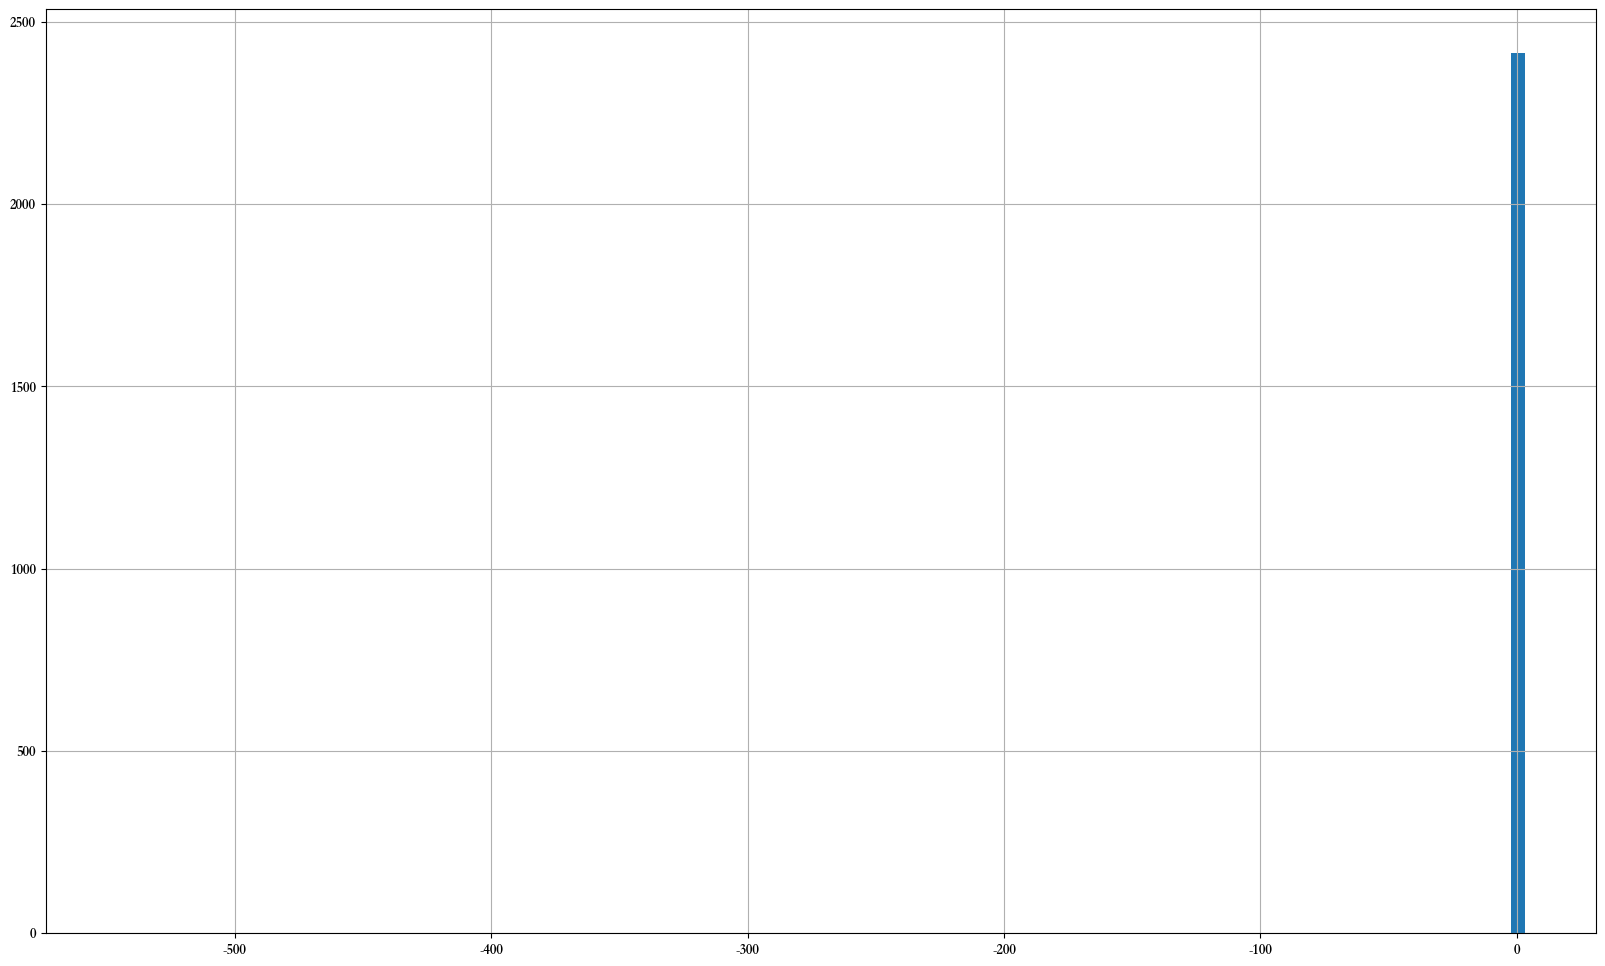

In [11]:
result.loc[:, '营业净利润率'].hist(figsize=(20, 12), bins=100)

可以看到营业净利润率差异非常大，我们来看一下硬件净利润率小于-300%的股票。


In [12]:
# 归母净利润	营业收入	营业总支出	营业支出	销售支出	管理支出	财务支出	平均总资产	平均总负债	营业净利润率	总资产周转率	资产负债率	净资产	权益乘数	净资产收益率
indexer = (slice(None), ["归母净利润", "营业收入", "营业总支出", "营业支出", "销售支出", "管理支出", "财务支出",
           "平均总资产", "平均总负债", "营业净利润率", "总资产周转率", "资产负债率", "净资产", "权益乘数", "净资产收益率"])
result.loc[result['营业净利润率'] <= -3, :].style.format(
    "{:.3e}", indexer).highlight_min(color='green').highlight_max(color='red')

,股票简称,归母净利润,营业收入,营业总支出,营业支出,销售支出,管理支出,财务支出,平均总资产,平均总负债,营业净利润率,总资产周转率,资产负债率,净资产,权益乘数,净资产收益率
股票代码,,,,,,,,,,,,,,,,
688062,迈威生物,-2.778e+09,1.718e+08,2.988e+09,4.520e+06,2.427e+08,5.825e+08,-6.470e+07,3.047e+09,1.025e+09,-1.617e+01,5.638e-02,3.364e-01,2.022e+09,1.507e+00,-1.374e+00
688176,亚虹医药,-8.819e+08,1.378e+07,1.009e+09,2.896e+06,5.252e+07,2.172e+08,-6.335e+07,1.738e+09,1.398e+08,-6.398e+01,7.931e-03,8.046e-02,1.598e+09,1.088e+00,-5.519e-01
688221,前沿生物,-9.458e+08,2.395e+08,1.306e+09,2.029e+08,1.793e+08,2.520e+08,2.616e+06,2.328e+09,5.866e+08,-3.949e+00,1.029e-01,2.519e-01,1.742e+09,1.337e+00,-5.430e-01
688302,海创药业,-9.019e+08,1.651e+06,1.013e+09,7.665e+05,8.359e+06,2.570e+08,-1.813e+07,1.340e+09,1.631e+08,-5.463e+02,1.232e-03,1.217e-01,1.177e+09,1.139e+00,-7.665e-01
688373,盟科药业,-8.677e+08,1.466e+08,1.134e+09,2.610e+07,2.561e+08,1.830e+08,2.139e+07,9.188e+08,1.916e+08,-5.917e+00,1.596e-01,2.086e-01,7.271e+08,1.264e+00,-1.193e+00


<Axes: >

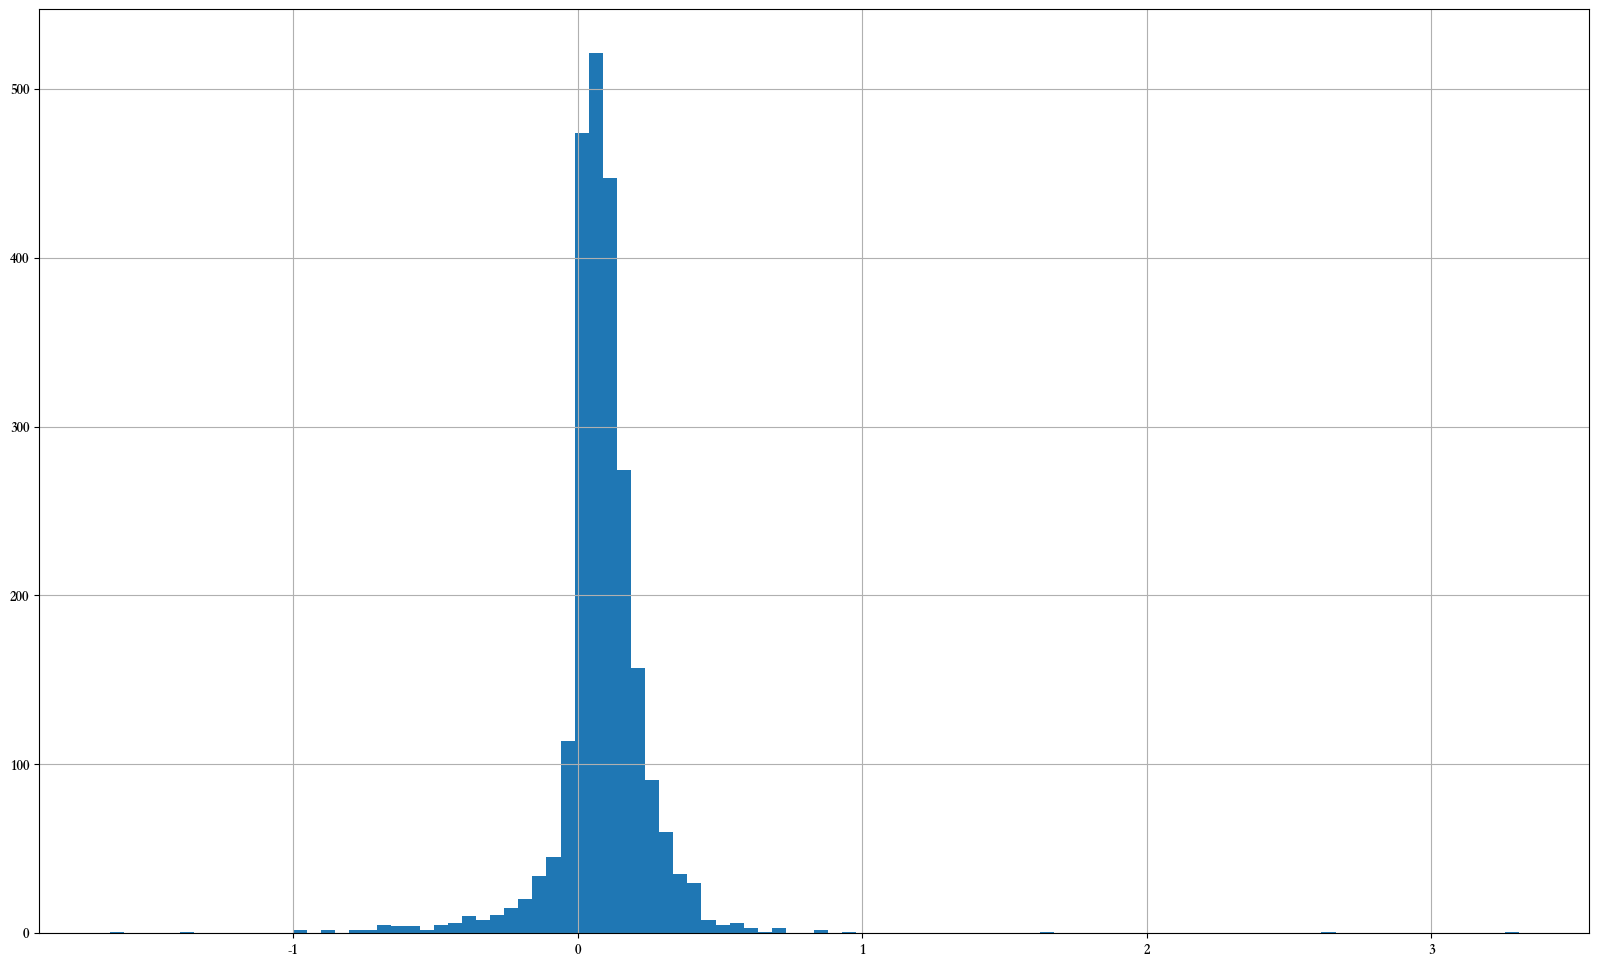

In [13]:
result.loc[result['营业净利润率'] > -3, '营业净利润率'].hist(figsize=(20, 12), bins=100)

- 查看总资产周转率的概况。


<Axes: >

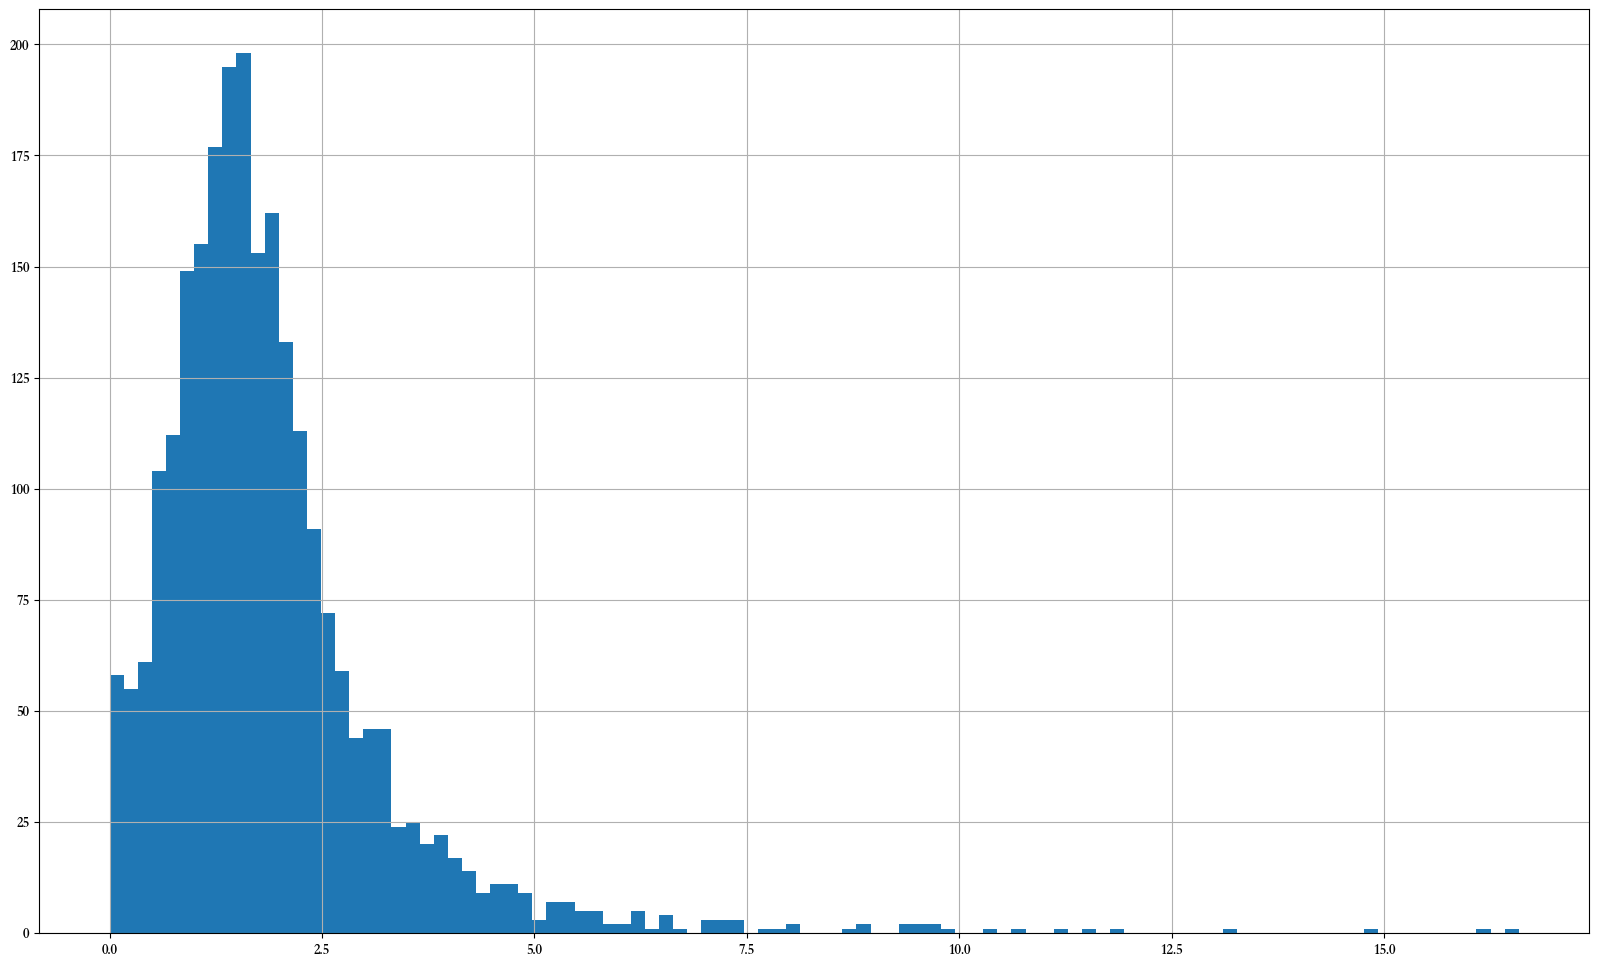

In [14]:
result.loc[:, '总资产周转率'].hist(figsize=(20, 12), bins=100)

- 查看权益乘数的概况。


<Axes: >

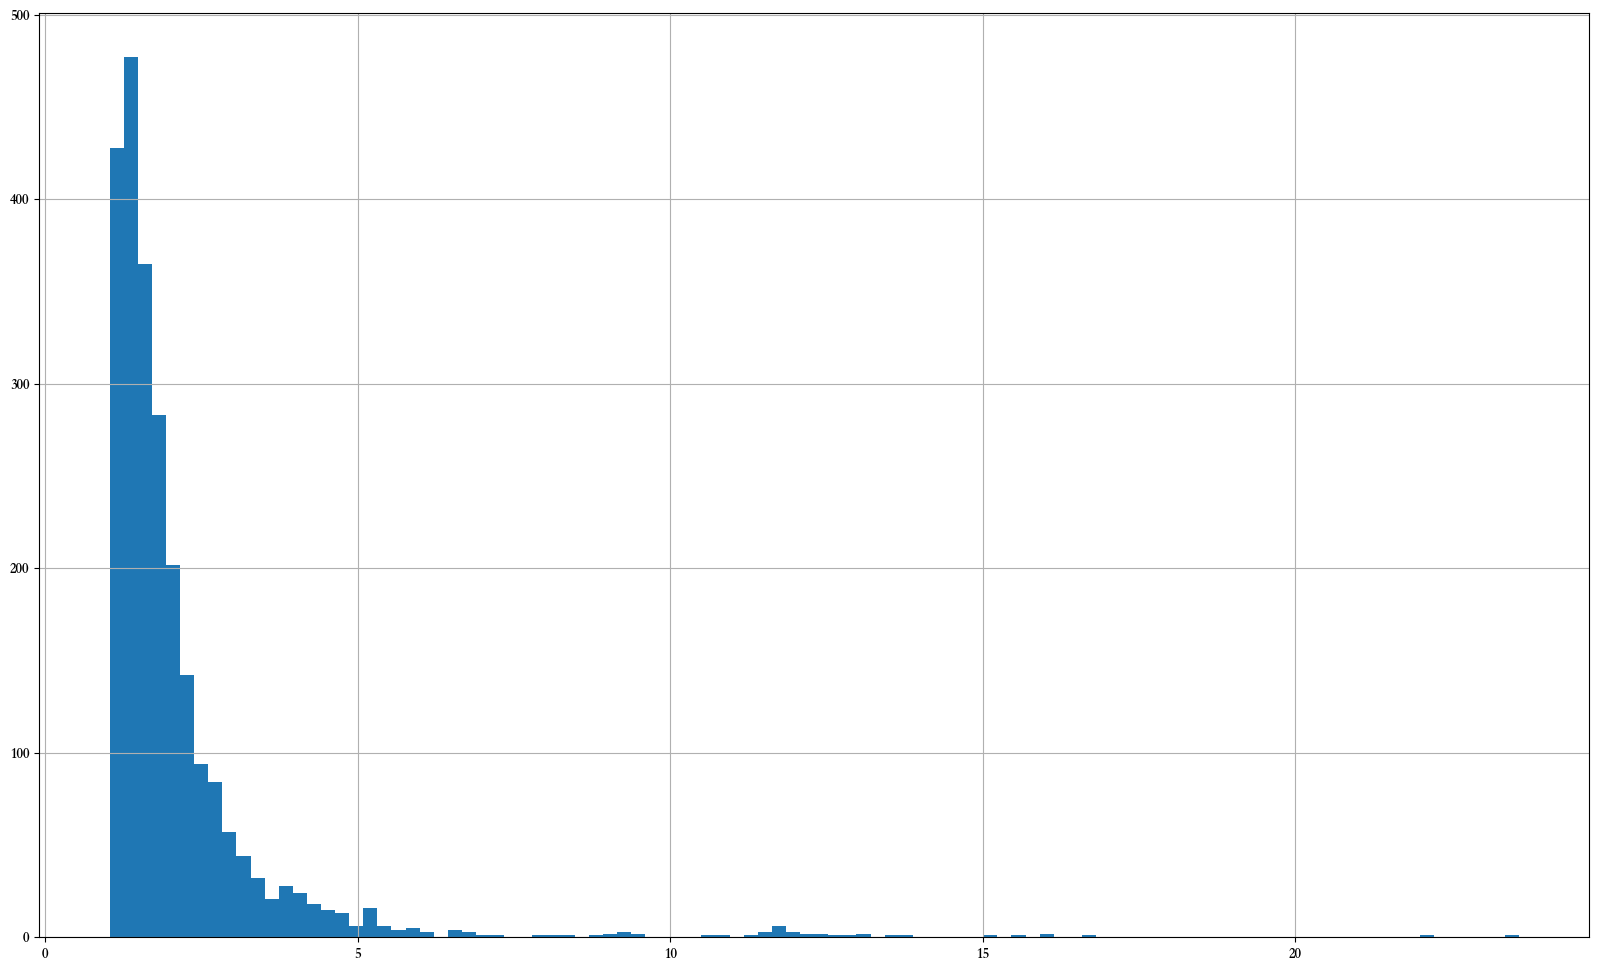

In [15]:
result.loc[:, '权益乘数'].hist(figsize=(20, 12), bins=100)

- 查看 ROE 的概况。


<Axes: >

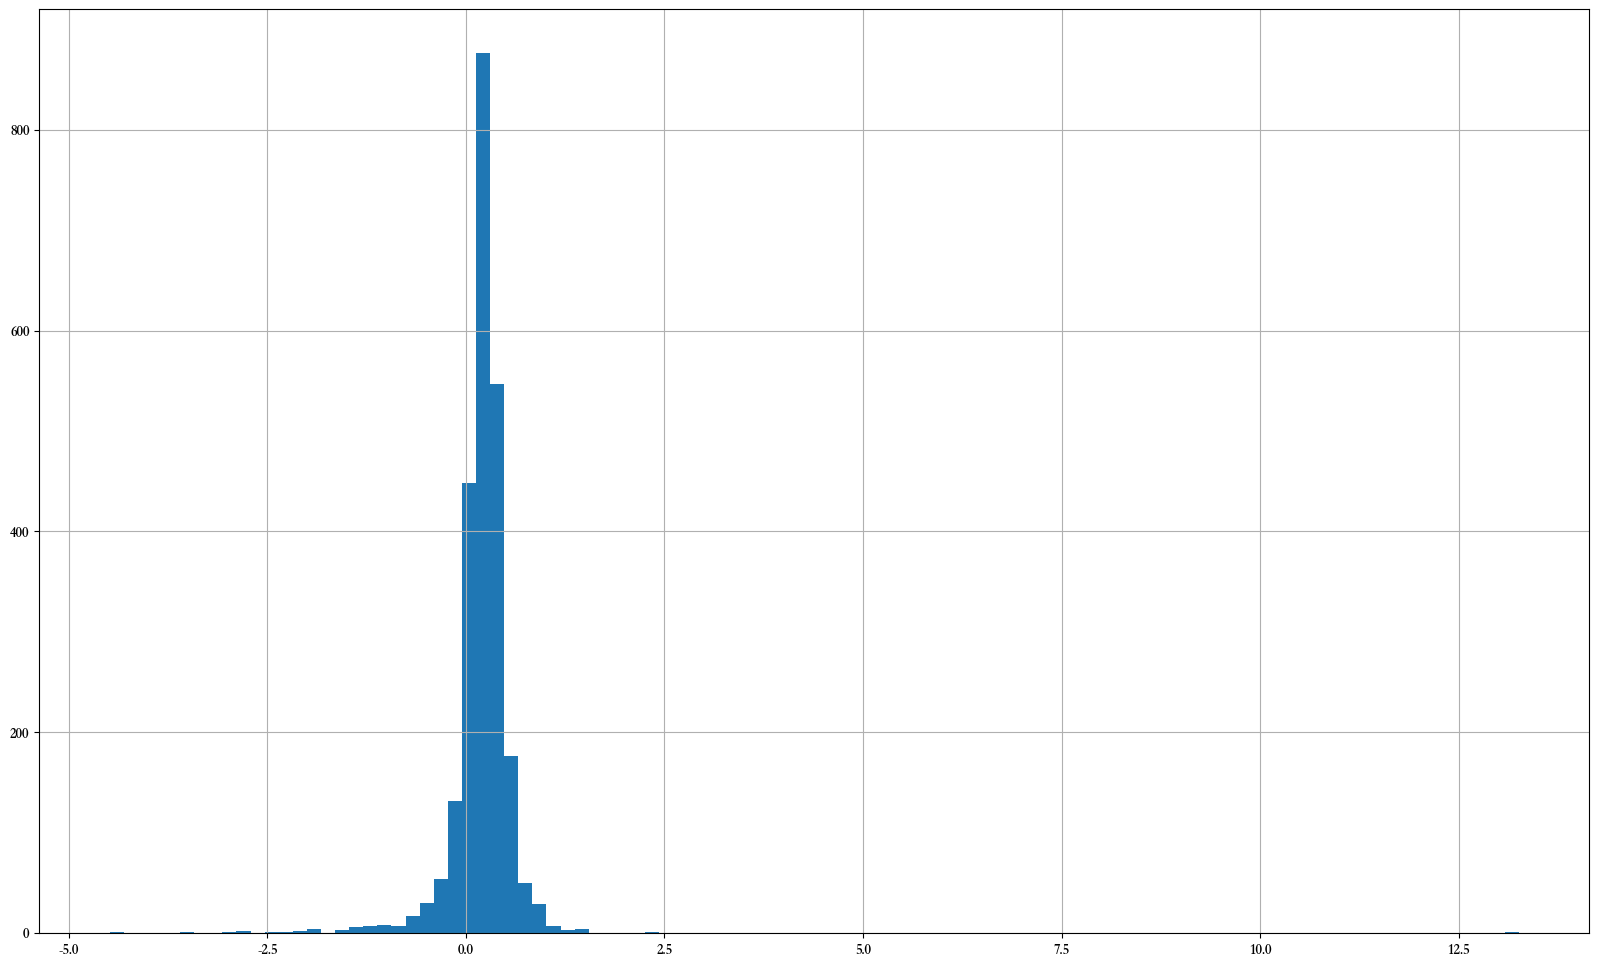

In [16]:
result.loc[:, '净资产收益率'].hist(figsize=(20, 12), bins=100)

### 板块分析

#### 概念板块分析


In [17]:
def cache(p: pl.Path, getter: Callable[[], pd.DataFrame]) -> pd.DataFrame:
    if not path.exists(p):
        df = getter()
        df.to_pickle(p)
    return pd.read_pickle(p)


def process_board(name: str, board: pd.DataFrame) -> pd.DataFrame:
    concept_boards_available = set(
        board.loc[:, '代码']).intersection(codes_real)
    concept_boards_available_list = [*concept_boards_available]
    # print(name, concept_boards_available)
    res = pd.DataFrame.from_dict({
        '股票代码': concept_boards_available_list,
        '净资产收益率': result.loc[concept_boards_available_list, '净资产收益率'],
    })
    res.set_index('股票代码', inplace=True)
    return res


# 可用的股票代码
codes_real = list(result.index.array)

In [18]:
DIR = pl.Path('data/concept_board')
os.makedirs(DIR, exist_ok=True)
concept_board = cache(
    pl.Path("data/concept_board.pkl"), lambda: ak.stock_board_concept_name_em())
concept_boards = {
    name: cache(pl.Path(DIR / f"{name.replace('/', ',')}.pkl"), lambda: ak.stock_board_concept_cons_em(name)) for name in concept_board['板块名称']
}
print(f"共计 {len(concept_boards)} 个概念板块。")

共计 455 个概念板块。


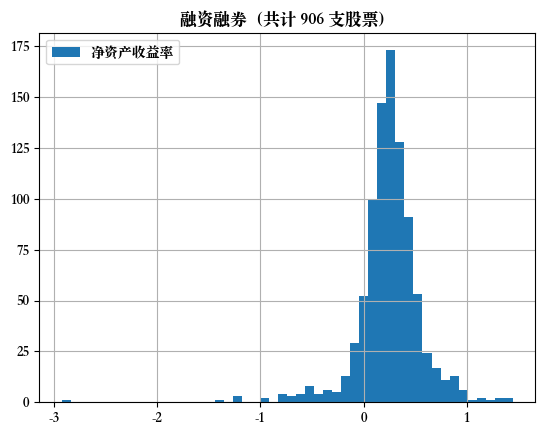

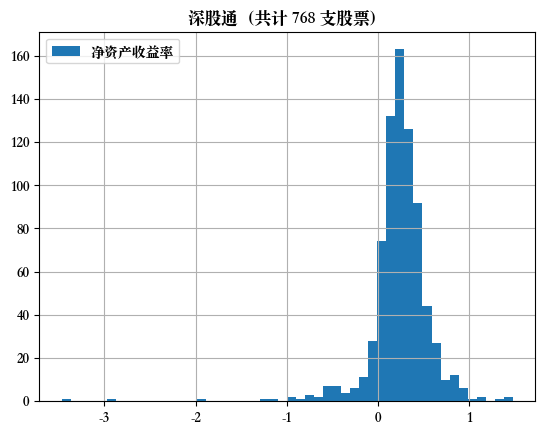

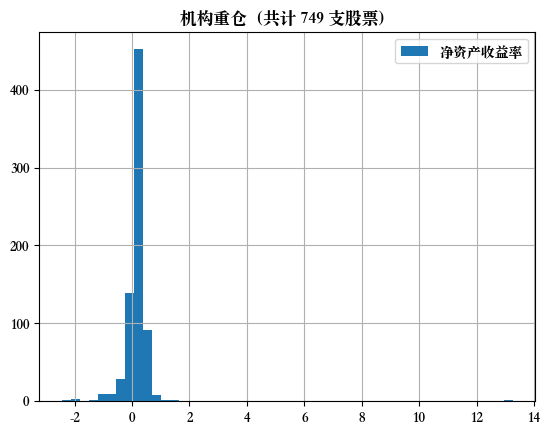

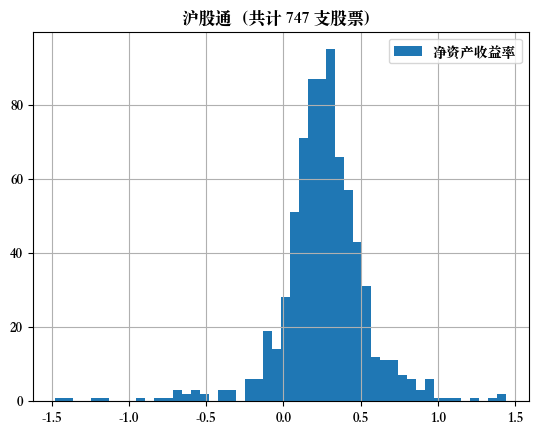

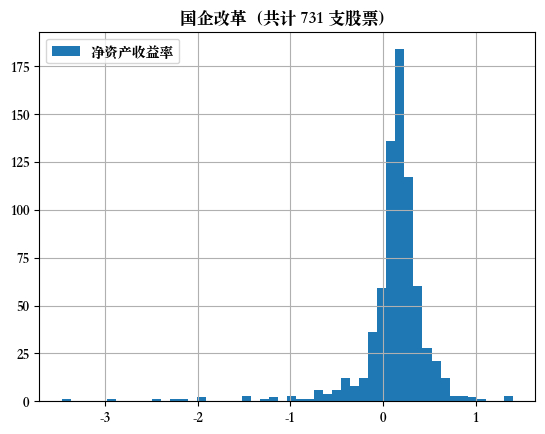

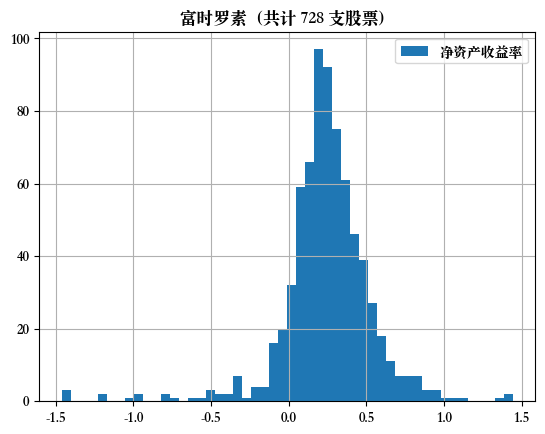

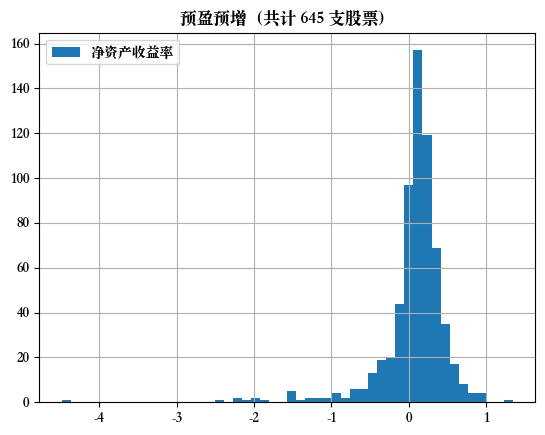

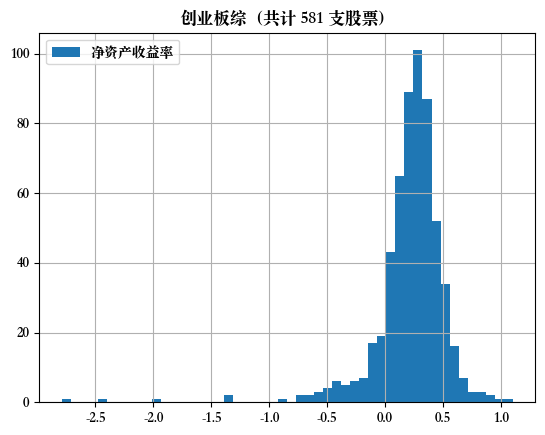

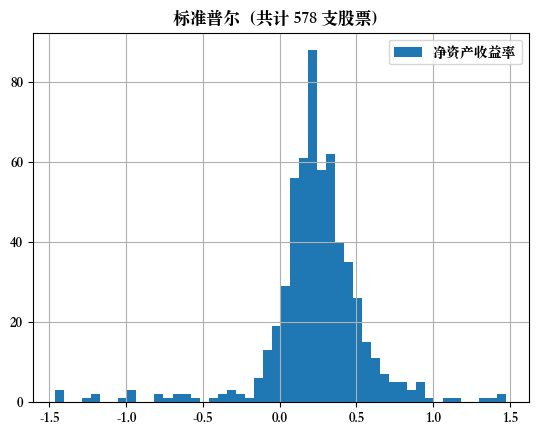

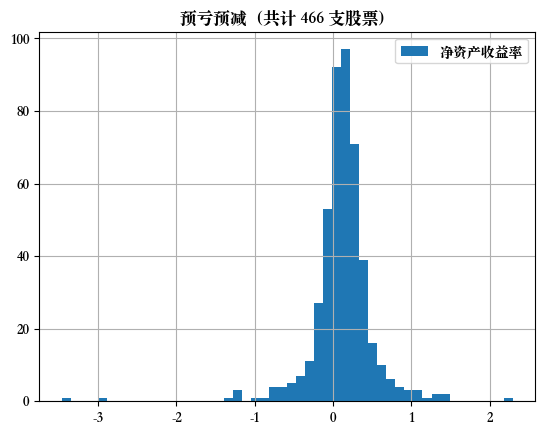

In [19]:
concept_boards_res = [(name, process_board(name, board))
                      for name, board in concept_boards.items()]
concept_boards_res.sort(
    key=lambda x: x[1].shape[0], reverse=True)
for name, board in concept_boards_res[:10]:
    board.hist(bins=50, legend=True)
    plt.title(name+f"（共计 {board.shape[0]} 支股票）")

#### 行业板块分析


In [20]:
DIR = pl.Path('data/industry_board')
os.makedirs(DIR, exist_ok=True)
industry_board = cache(
    pl.Path("data/industry_board.pkl"), lambda: ak.stock_board_industry_name_em())
industry_boards = {
    name: cache(pl.Path(DIR / f"{name}.pkl"), lambda: ak.stock_board_industry_cons_em(name)) for name in industry_board['板块名称']
}
print(f"共计 {len(industry_boards)} 个行业板块。")

共计 86 个行业板块。


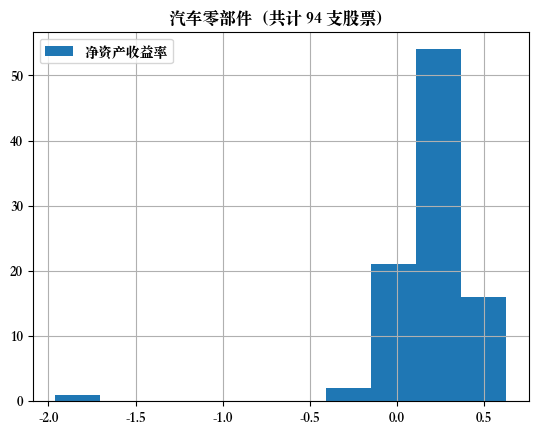

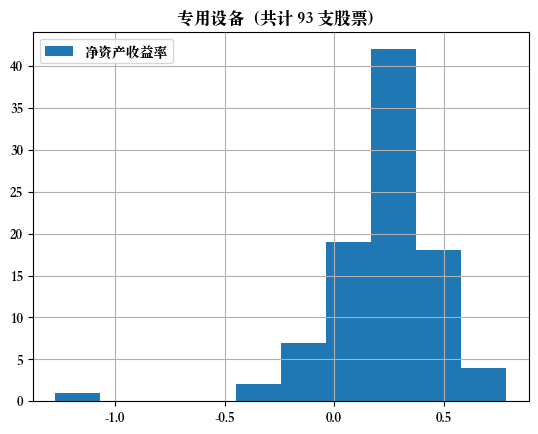

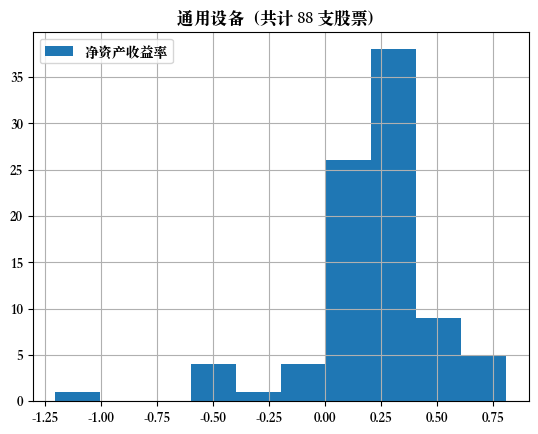

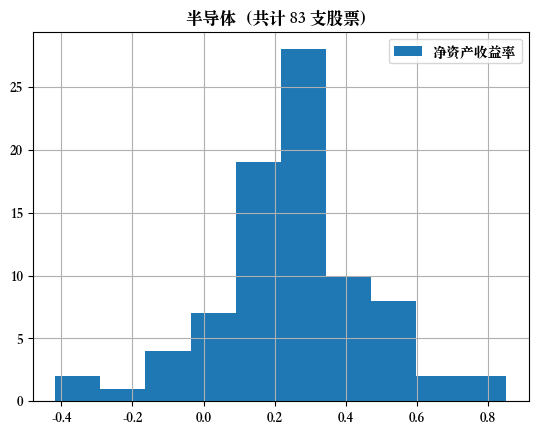

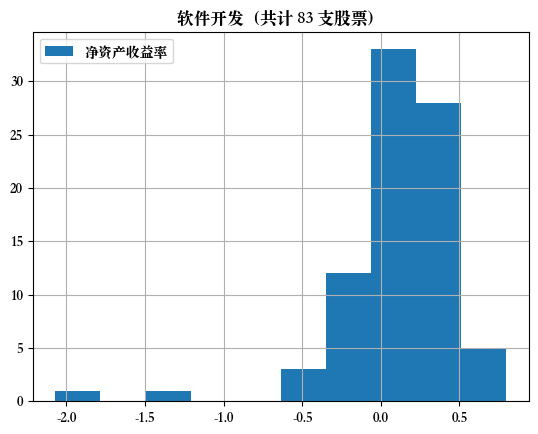

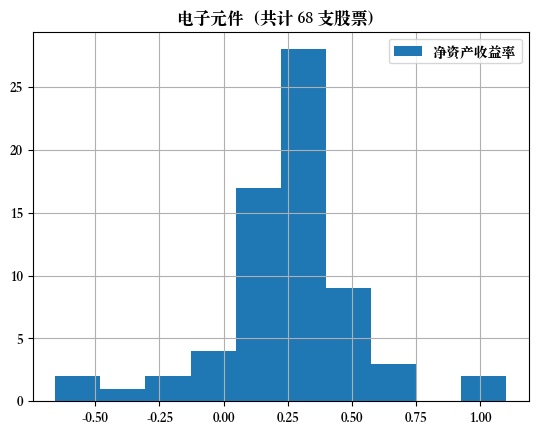

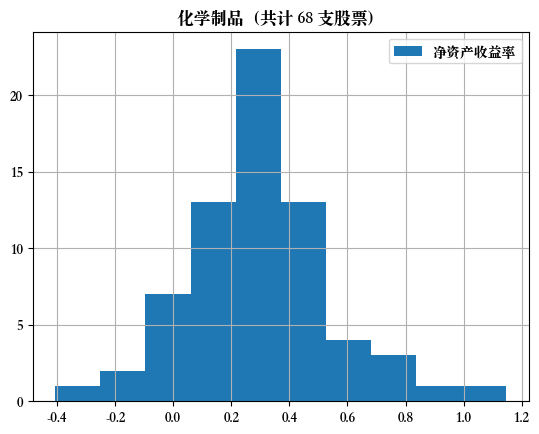

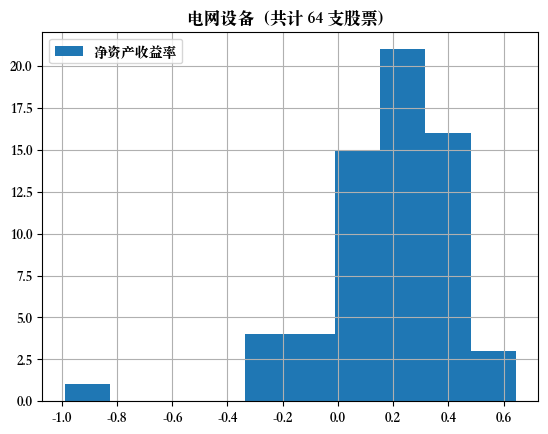

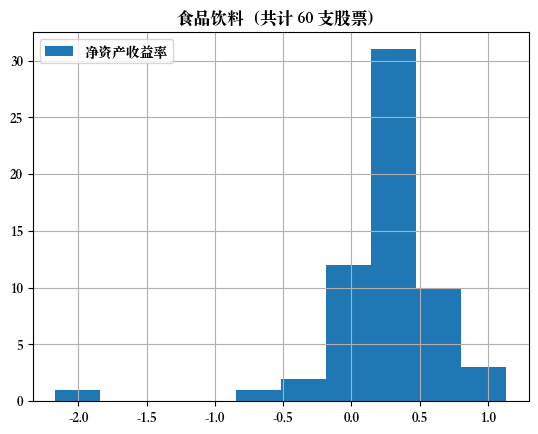

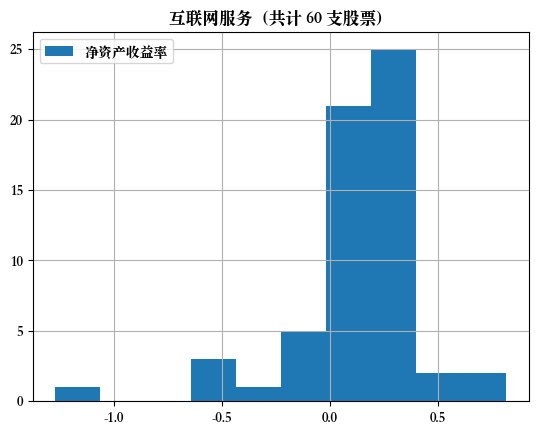

In [21]:
for name, board in industry_boards.items():
    industry_boards_available = set(
        codes_real).intersection(board.loc[:, '代码'])

industry_boards_res = [(name, process_board(name, board))
                       for name, board in industry_boards.items()]
industry_boards_res.sort(
    key=lambda x: x[1].shape[0], reverse=True)
for name, board in industry_boards_res[:10]:
    board.hist(bins=10, legend=True)
    plt.title(name+f"（共计 {board.shape[0]} 支股票）")

### 杜邦分析


In [22]:
x = result.iloc[0]
s = f"""
```mermaid
classDiagram
净资产收益率 -- 总资产净利率
	净资产收益率 : {x.loc['净资产收益率'] * 100:.2f}%
	净资产收益率 : ROE(净利润 /  股东权益)
	总资产净利率 : {x.loc['营业净利润率'] * x.loc['总资产周转率'] * 100:.2f}% = （营业净利润率 X 总资产周转率）
	总资产净利率 : ProfitMagin(净利润 /  营业收入)
净资产收益率 -- 归属母公司股东的净利润占比
	归属母公司股东的净利润占比 : ? %
	归属母公司股东的净利润占比 : ratio(母公司股东的净利润/净利润)
净资产收益率 -- 权益乘数
	权益乘数 : {x.loc['权益乘数']:.2f} = 1 ➗ （1 - 资产负债率）
	权益乘数 : EquityMultiplier(总资产 /  股东权益)
	
总资产净利率 -- 营业净利润率
	营业净利润率 : {x.loc['营业净利润率'] * 100:.2f}% = （净利润 ➗ 营业总收入）
总资产净利率 -- 总资产周转率
	总资产周转率 : {x.loc['总资产周转率']:.3f}次 =（营业总收入 ➗ 资产总额）
权益乘数 -- 资产负债率
	资产负债率  : {x.loc['资产负债率']*100:.2f}% =（负债总额 ➗ 资产总额）
	资产负债率  : ratio(负债总额 / 资产总额)

营业净利润率 -- 净利润
	净利润 : {x.loc['归母净利润']/1e8:.2f}亿 = 收入总额 - 成本总额
营业净利润率 -- 营业总收入
	营业总收入 : {x.loc['营业收入']/1e8:.2f}亿
总资产周转率 -- 营业总收入
总资产周转率 -- 资产总额
	资产总额 : {x.loc['平均总资产']/1e8:.2f}亿 = 流动资产 + 非流动资产
资产负债率 -- 　负债总额
	负债总额 : {x.loc['平均总负债']/1e8:.2f}亿
资产负债率 -- 　资产总额


净利润 -- 收入总额
	收入总额 : {x.loc['营业收入']/1e8:.2f}亿
净利润 -- 成本总额
	成本总额 : {x.loc['营业总支出']/1e8:.2f}亿
资产总额 -- 流动资产
	流动资产 : ? 亿
资产总额 -- 非流动资产
	非流动资产 : ? 亿

收入总额 -- 包括1
	包括1 : 营业总收入
	包括1 : {x.loc['营业收入']/1e8:.2f}亿
	包括1 : ...
成本总额 -- 包括2
	包括2 : 营业成本
	包括2 : {x.loc['营业支出']/1e8:.2f}亿
	包括2 : 销售支出
	包括2 : {x.loc['销售支出']/1e8:.2f}亿
	包括2 : 管理支出
	包括2 : {x.loc['管理支出']/1e8:.2f}亿
	包括2 : 财务支出
	包括2 : {x.loc['财务支出']/1e8:.2f}亿
	包括2 : ...
流动资产 -- 包括4
	包括4 : ...
非流动资产 -- 包括5_1
	包括5_1 : ...
非流动资产 -- 包括5_2
	包括5_2 : --
```
"""
print(s)


```mermaid
classDiagram
净资产收益率 -- 总资产净利率
	净资产收益率 : 30.68%
	净资产收益率 : ROE(净利润 /  股东权益)
	总资产净利率 : 2.55% = （营业净利润率 X 总资产周转率）
	总资产净利率 : ProfitMagin(净利润 /  营业收入)
净资产收益率 -- 归属母公司股东的净利润占比
	归属母公司股东的净利润占比 : ? %
	归属母公司股东的净利润占比 : ratio(母公司股东的净利润/净利润)
净资产收益率 -- 权益乘数
	权益乘数 : 12.02 = 1 ➗ （1 - 资产负债率）
	权益乘数 : EquityMultiplier(总资产 /  股东权益)
	
总资产净利率 -- 营业净利润率
	营业净利润率 : 24.96% = （净利润 ➗ 营业总收入）
总资产净利率 -- 总资产周转率
	总资产周转率 : 0.102次 =（营业总收入 ➗ 资产总额）
权益乘数 -- 资产负债率
	资产负债率  : 91.68% =（负债总额 ➗ 资产总额）
	资产负债率  : ratio(负债总额 / 资产总额)

营业净利润率 -- 净利润
	净利润 : 1283.07亿 = 收入总额 - 成本总额
营业净利润率 -- 营业总收入
	营业总收入 : 5139.77亿
总资产周转率 -- 营业总收入
总资产周转率 -- 资产总额
	资产总额 : 50278.15亿 = 流动资产 + 非流动资产
资产负债率 -- 　负债总额
	负债总额 : 46095.86亿
资产负债率 -- 　资产总额


净利润 -- 收入总额
	收入总额 : 5139.77亿
净利润 -- 成本总额
	成本总额 : 3525.89亿
资产总额 -- 流动资产
	流动资产 : ? 亿
资产总额 -- 非流动资产
	非流动资产 : ? 亿

收入总额 -- 包括1
	包括1 : 营业总收入
	包括1 : 5139.77亿
	包括1 : ...
成本总额 -- 包括2
	包括2 : 营业成本
	包括2 : 0.00亿
	包括2 : 销售支出
	包括2 : 0.00亿
	包括2 : 管理支出
	包括2 : 1432.83亿
	包括2 : 财务支出
	包括2 : 0.00亿
	包括2 : ...
流动资产 -- 包括4
	包括4

## 实验总结与自评分


## 感谢和收获
